In [15]:
import os
import csv
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
from collections import defaultdict

from utils import savefig

plt.rcParams['font.size'] = 16

In [16]:
""" recall probability multiple models """
exp_names = ["setup_gru_negmementreg_gamma06-9", "setup_gru_negmementreg_gamma06-62",
             "setup_gru_negmementreg_gamma06-14", "setup_gru_negmementreg_gamma06-18"]
recall_probs = []
for exp in exp_names:
    with open("./experiments/RL/figures/cogsci/ValueMemoryGRU/{}/recall_probability.csv".format(exp), "r") as f:
        reader = csv.reader(f)
        for row in reader:
            for i in range(len(row)):
                row[i] = float(row[i])
            recall_probs.append(np.array(row))
            break
nsteps = int((len(recall_probs[0])-1)/2) # 7

colors = ["#F8961E", "#F9C74F", "#90BE6D", "#43AA8B"]

plt.figure(figsize=(4.2, 3.3), dpi=180)
for i in range(len(exp_names)):
    plt.scatter(np.arange(-nsteps, 0), recall_probs[i][:nsteps], c='w', marker="o", edgecolors=ColorConverter().to_rgba(colors[i], alpha=1.0), zorder=2)
    plt.plot(np.arange(-nsteps, 0), recall_probs[i][:nsteps], c=colors[i], alpha=0.75, zorder=1, label="seed {}".format(i+1))
    plt.scatter(np.arange(1, nsteps+1), recall_probs[i][nsteps+1:], c='w', marker="o", edgecolors=ColorConverter().to_rgba(colors[i], alpha=1.0), zorder=2)
    plt.plot(np.arange(1, nsteps+1), recall_probs[i][nsteps+1:], c=colors[i], alpha=0.75, zorder=1)

    # plt.scatter(np.arange(-nsteps, 0), recall_probs[i][:nsteps], c='w', marker="o", edgecolors=ColorConverter().to_rgba('k', alpha=1-i*0.25), zorder=2)
    # plt.plot(np.arange(-nsteps, 0), recall_probs[i][:nsteps], c='k', alpha=1-i*0.25, label="seed {}".format(i+1), zorder=1)
    # plt.scatter(np.arange(1, nsteps+1), recall_probs[i][nsteps+1:], c='w', marker="o", edgecolors=ColorConverter().to_rgba('k', alpha=1-i*0.25), zorder=2)
    # plt.plot(np.arange(1, nsteps+1), recall_probs[i][nsteps+1:], c='k', alpha=1-i*0.25, zorder=1)
    # plt.scatter(np.array([0]), recall_probs[i][nsteps], c='r', marker="o", alpha=1-i*0.2)
plt.xlabel("lag")
plt.ylabel("conditional\nrecall probability")
    # title = title if title else "conditional recall probability"
    # plt.title(title)

plt.legend(fontsize=11)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.show()
savefig("./figures", "crp_different_colored", format="svg")
plt.close()


In [10]:
exp_names = []
temporal_discount_factors = []
exp_names.append("setup_gru_negmementreg")
temporal_discount_factors.append(0.0)
for i in range(1, 10):
    exp_names.append("setup_gru_negmementreg_gamma0{}".format(i))
    temporal_discount_factors.append(float(i)/10)
exp_names.append("setup_gru_negmementreg_gamma")
temporal_discount_factors.append(1.0)

accuracy_dict = {}
forward_asymmetry_dict = {}
temporal_factor_dict = {}
index_decoding_acc_dict = {}

for exp in exp_names:
    accuracy_dict[exp] = []
    forward_asymmetry_dict[exp] = []
    temporal_factor_dict[exp] = []
    index_decoding_acc_dict[exp] = []
    for i in range(20):
        run_name = exp + "-{}".format(i)
        with open("./experiments/RL/figures/cogsci/ValueMemoryGRU/{}/contiguity_effect.csv".format(run_name), "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0])>=0.65:
                    accuracy_dict[exp].append(float(row[0]))
                    forward_asymmetry_dict[exp].append(float(row[1]))
                    temporal_factor_dict[exp].append(float(row[2]))
                    data = np.load("./experiments/RL/figures/cogsci/ValueMemoryGRU/{}/pc_selectivity_encoding.npz".format(run_name), allow_pickle=True)
                    index_decoding_acc_dict[exp].append(data['selectivity'][1][-1])


""" temporal discount factor - forward asymmetry & temporal factor """
mean_forward_asymmetry = []
std_forward_asymmetry = []
mean_temporal_factor = []
std_temporal_factor = []
mean_index_decoding_acc = []
std_index_decoding_acc = []
for exp in exp_names:
    mean_forward_asymmetry.append(np.mean(forward_asymmetry_dict[exp]))
    std_forward_asymmetry.append(np.std(forward_asymmetry_dict[exp]))
    mean_temporal_factor.append(np.mean(temporal_factor_dict[exp]))
    std_temporal_factor.append(np.std(temporal_factor_dict[exp]))
    mean_index_decoding_acc.append(np.mean(index_decoding_acc_dict[exp]))
    std_index_decoding_acc.append(np.std(index_decoding_acc_dict[exp]))


fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
plt.errorbar(temporal_discount_factors, mean_forward_asymmetry, yerr=std_forward_asymmetry, fmt='o',
            alpha=0.8, capsize=3)
plt.xlabel("temporal discount factor ($\gamma$)")
plt.ylabel("forward asymmetry (FA)")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
savefig("./figures", "tdf_forw_asym", format="svg")
# plt.show()
plt.close()

In [4]:
noise = [0, 0.2, 0.4, 0.6, 0.8, 1]
threshold = [0.8, 0.7, 0.6]
tf_high = 0.875 # 0.875 # 0.833 # 0.75
# tf_low = np.array([0.37, 0.41, 0.43]).reshape(-1, 1)
tf_low = 0.0

# all models with performance > 70

accuracy = []
forward_asymmetry = []
temporal_factor = []
index_coding_prop = []
noises = []
tdr_index_enc = []
tdr_index_rec = []

for i, n in enumerate(noise):
    exp_path = Path("./experiments/RL/Noise/NBack/figures/ValueMemoryGRU/setup_seq16_noise{}".format(str(n).replace(".", "")))
    tdr_path = Path("./experiments/RL/Noise/NBack/figures/tdr/ValueMemoryGRU/setup_seq16_noise{}".format(str(n).replace(".", "")))
    for k in range(100):
        if not os.path.exists(exp_path / str(k) / "contiguity_effect.csv"):
            # print(exp_path / str(k) / "contiguity_effect.csv")
            continue
        with open(exp_path / str(k) / "contiguity_effect.csv") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0]) >= 0.7:
                    noises.append(n)
                    accuracy.append(float(row[0]))
                    forward_asymmetry.append(float(row[1]))
                    temporal_factor.append(float(row[2]))
                    data = np.load(exp_path / str(k) / "pc_selectivity_recalling.npz", allow_pickle=True)
                    index_coding_prop.append(data['selectivity'][1][-1])
                    tdr_data = np.load(tdr_path / str(k) / "tdr_variance.npy", allow_pickle=True)
                    tdr_index_enc.append(tdr_data[0] / (tdr_data[0] + tdr_data[1]))
                    tdr_index_rec.append(tdr_data[2] / (tdr_data[2] + tdr_data[3]))
                    # accuracy[i].append(float(row[0]))
                    # forward_asymmetry[i].append(float(row[1]))
                    # temporal_factor[i].append(float(row[2]))
                    # data = np.load(exp_path / str(k) / "pc_selectivity_recalling.npz", allow_pickle=True)
                    # index_coding_prop[i].append(data['selectivity'][1][-1])

                    # accuracy[i, j] += float(row[0])
                    # forward_asymmetry[i, j] += float(row[1])
                    # temporal_factor[i, j] += float(row[2])
                    # data = np.load(exp_path / str(k) / "pc_selectivity_recalling.npz", allow_pickle=True)
                    # index_coding_prop[i, j] += data['selectivity'][1][-1]
                        # if data['selectivity'][1][-1] >= threshold[i]:
                        #     index_coding_prop[i, j] += 1.0

noises = np.array(noises)
accuracy = np.array(accuracy)
forward_asymmetry = np.array(forward_asymmetry)
temporal_factor = np.array(temporal_factor)
index_coding_prop = np.array(index_coding_prop)
tdr_index_enc = np.array(tdr_index_enc)
tdr_index_rec = np.array(tdr_index_rec)

# temporal_factor = (temporal_factor - tf_low) / (tf_high - tf_low)



In [14]:
fa_label = np.zeros(len(noise))
fa_label_std = np.zeros(len(noise))
index_code_label = np.zeros(len(noise))
index_code_label_std = np.zeros(len(noise))
for i, n in enumerate(noise):
    # l = label[noises == n]
    fa = forward_asymmetry[noises == n]
    fa_label[i] = np.mean(fa)
    fa_label_std[i] = np.std(fa)
    index_code = index_coding_prop[noises == n]
    index_code_label[i] = np.mean(index_code)
    index_code_label_std[i] = np.std(index_code)

plt.figure(figsize=(4, 3.5), dpi=180)
plt.errorbar(noise, fa_label, yerr=fa_label_std, fmt='o-', label="FA", alpha=0.4)
plt.errorbar(noise, index_code_label, yerr=index_code_label_std, fmt='o-', color="tab:green", label="index decoding", alpha=0.4)
# plt.plot(noise, fa_label)
plt.xlabel("noise proportion")
plt.ylabel("forward asymmetry")
plt.legend(fontsize=11)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
savefig("./figures/strategy/relation", "fa_noise", format='svg')
# plt.show()
plt.close()

In [18]:
plt.figure(figsize=(4, 3.3), dpi=180)
plt.scatter(np.arange(-nsteps, 0), recall_probs[2][:nsteps], c='b', zorder=2)
plt.plot(np.arange(-nsteps, 0), recall_probs[2][:nsteps], c='k', zorder=1)
plt.scatter(np.arange(1, nsteps+1), recall_probs[2][nsteps+1:], c='b', zorder=2)
plt.plot(np.arange(1, nsteps+1), recall_probs[2][nsteps+1:], c='k', zorder=1)
plt.scatter(np.array([0]), recall_probs[2][nsteps], c='r')
plt.xlabel("lag")
plt.ylabel("conditional\nrecall probability")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
savefig("./figures", "crp_seed2", format="svg")
# plt.show()
plt.close()

### temporal discount factor - strategy

In [3]:
exp_path = Path("./experiments/FreeRecall/VaryGamma/figures/ValueMemoryGRU")

exp_names = []
temporal_discount_factors = []
exp_names.append("setup_gamma0")
temporal_discount_factors.append(0.0)
for i in range(1, 10):
    exp_names.append("setup_gamma0{}".format(i))z
    temporal_discount_factors.append(float(i)/10)
exp_names.append("setup_gamma1")
temporal_discount_factors.append(1.0)

accuracy_dict = defaultdict(list)
forward_asymmetry_dict = defaultdict(list)
temporal_factor_dict = defaultdict(list)

item_enc_acc_dict = defaultdict(list)
item_enc_acc_last_dict = defaultdict(list)
index_enc_acc_dict = defaultdict(list)
item_rec_acc_dict = defaultdict(list)
item_rec_acc_last_dict = defaultdict(list)
index_rec_acc_dict = defaultdict(list)


for exp in exp_names:
    for i in range(20):
        with open(exp_path/exp/str(i)/"contiguity_effect.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0])>=0.70:
                    accuracy_dict[exp].append(float(row[0]))
                    forward_asymmetry_dict[exp].append(float(row[1]))
                    temporal_factor_dict[exp].append(float(row[2]))
                    # data = np.load("./experiments/RL/figures/cogsci/ValueMemoryGRU/{}/pc_selectivity_encoding.npz".format(run_name), allow_pickle=True)
                    # index_decoding_acc_dict[exp].append(data['selectivity'][1][-1])

                    ridge_classifier_stat = pickle.load(open(exp_path/exp/str(i)/"decoding_data"/"ridge_classifier_stat.pkl".format(exp, i), "rb"))
                    item_enc_acc_dict[exp].append(ridge_classifier_stat['item_enc_acc'])
                    item_enc_acc_last_dict[exp].append(ridge_classifier_stat['item_enc_acc_last'])
                    index_enc_acc_dict[exp].append(ridge_classifier_stat['index_enc_acc'])
                    item_rec_acc_dict[exp].append(ridge_classifier_stat['item_rec_acc'])
                    item_rec_acc_last_dict[exp].append(ridge_classifier_stat['item_rec_acc_last'])
                    index_rec_acc_dict[exp].append(ridge_classifier_stat['index_rec_acc'])

accuracy_mean, accuracy_std = [], []
forward_asymmetry_mean, forward_asymmetry_std = [], []
temporal_factor_mean, temporal_factor_std = [], []

item_enc_acc_mean, item_enc_acc_std = [], []
item_enc_acc_last_mean, item_enc_acc_last_std = [], []
index_enc_acc_mean, index_enc_acc_std = [], []

item_rec_acc_mean, item_rec_acc_std = [], []
item_rec_acc_last_mean, item_rec_acc_last_std = [], []
index_rec_acc_mean, index_rec_acc_std = [], []

for exp in exp_names:
    print(exp, len(accuracy_dict[exp]))

    accuracy_mean.append(np.mean(accuracy_dict[exp]))
    accuracy_std.append(np.std(accuracy_dict[exp]))

    forward_asymmetry_mean.append(np.mean(forward_asymmetry_dict[exp]))
    forward_asymmetry_std.append(np.std(forward_asymmetry_dict[exp]))

    temporal_factor_mean.append(np.mean(temporal_factor_dict[exp]))
    temporal_factor_std.append(np.std(temporal_factor_dict[exp]))

    item_enc_acc_mean.append(np.mean(item_enc_acc_dict[exp]))
    item_enc_acc_std.append(np.std(item_enc_acc_dict[exp]))

    item_enc_acc_last_mean.append(np.mean(item_enc_acc_last_dict[exp]))
    item_enc_acc_last_std.append(np.std(item_enc_acc_last_dict[exp]))

    index_enc_acc_mean.append(np.mean(index_enc_acc_dict[exp]))
    index_enc_acc_std.append(np.std(index_enc_acc_dict[exp]))

    item_rec_acc_mean.append(np.mean(item_rec_acc_dict[exp]))
    item_rec_acc_std.append(np.std(item_rec_acc_dict[exp]))

    item_rec_acc_last_mean.append(np.mean(item_rec_acc_last_dict[exp]))
    item_rec_acc_last_std.append(np.std(item_rec_acc_last_dict[exp]))

    index_rec_acc_mean.append(np.mean(index_rec_acc_dict[exp]))
    index_rec_acc_std.append(np.std(index_rec_acc_dict[exp]))


setup_gamma0 20
setup_gamma01 20
setup_gamma02 20
setup_gamma03 20
setup_gamma04 20
setup_gamma05 20
setup_gamma06 20
setup_gamma07 20
setup_gamma08 20
setup_gamma09 20
setup_gamma1 19


In [9]:
def plot_mean_std(x, y, yerr, x_label, y_label, color="tab:blue", figname=None):
    fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
    x = np.array(x)
    plt.xticks(x[np.arange(0, len(x), 2)])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/vary_gamma", figname)
    else:
        plt.show()
    plt.close()


# plot_mean_std(temporal_discount_factors, accuracy_mean, accuracy_std, "Temporal discount factor", "Accuracy")
plot_mean_std(temporal_discount_factors, forward_asymmetry_mean, forward_asymmetry_std, "Temporal discount factor", "Forward asymmetry", figname="gamma_fa")
plot_mean_std(temporal_discount_factors, temporal_factor_mean, temporal_factor_std, "Temporal discount factor", "Temporal factor", color="tab:orange", figname="gamma_tf")

# plot_mean_std(temporal_discount_factors, item_enc_acc_mean, item_enc_acc_std, "Temporal discount factor", "Item encoding accuracy")
# plot_mean_std(temporal_discount_factors, item_enc_acc_last_mean, item_enc_acc_last_std, "Temporal discount factor", "Item encoding accuracy (last)")
plot_mean_std(temporal_discount_factors, index_enc_acc_mean, index_enc_acc_std, "Temporal discount factor", "Index encoding accuracy", color="tab:green", figname="gamma_index_enc_acc")

# plot_mean_std(temporal_discount_factors, item_rec_acc_mean, item_rec_acc_std, "Temporal discount factor", "Item recall accuracy")
# plot_mean_std(temporal_discount_factors, item_rec_acc_last_mean, item_rec_acc_last_std, "Temporal discount factor", "Item recall accuracy (last)")
# plot_mean_std(temporal_discount_factors, index_rec_acc_mean, index_rec_acc_std, "Temporal discount factor", "Index recall accuracy")
    


### Accuracy - strategy

In [14]:
accuracy_list = []
forward_asymmetry_list = []
temporal_factor_list = []

item_enc_acc_list = []
item_enc_acc_last_list = []
index_enc_acc_list = []

item_rec_acc_list = []
item_rec_acc_last_list = []
index_rec_acc_list = []


for exp in exp_names:
    for i in range(20):
        with open(exp_path/exp/str(i)/"contiguity_effect.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0])>=0.70:
                    accuracy_list.append(float(row[0]))
                    forward_asymmetry_list.append(float(row[1]))
                    temporal_factor_list.append(float(row[2]))

                    ridge_classifier_stat = pickle.load(open(exp_path/exp/str(i)/"decoding_data"/"ridge_classifier_stat.pkl".format(exp, i), "rb"))
                    item_enc_acc_list.append(ridge_classifier_stat['item_enc_acc'])
                    item_enc_acc_last_list.append(ridge_classifier_stat['item_enc_acc_last'])
                    index_enc_acc_list.append(ridge_classifier_stat['index_enc_acc'])
                    item_rec_acc_list.append(ridge_classifier_stat['item_rec_acc'])
                    item_rec_acc_last_list.append(ridge_classifier_stat['item_rec_acc_last'])
                    index_rec_acc_list.append(ridge_classifier_stat['index_rec_acc'])


In [16]:
def plot_scatter(x, y, x_label, y_label, color="tab:blue", figname=None):
    plt.figure(figsize=(4, 3.5), dpi=180)
    plt.scatter(x, y, alpha=0.5, color=color)

    # plt.scatter([x[9]], [y[9]], color='k', alpha=0.5)
    # plt.text(x[9]-0.02, y[9]-0.02, "1", fontsize=11)
    # plt.scatter([x[62]], [y[62]], color='k', alpha=0.5)
    # plt.text(x[62]-0.02, y[62]+0.02, "2", fontsize=11)
    # plt.scatter([x[14]], [y[14]], color='k', alpha=0.5)
    # plt.text(x[14]-0.02, y[14]+0.02, "3", fontsize=11)
    # plt.scatter([x[18]], [y[18]], color='k', alpha=0.5)
    # plt.text(x[18]-0.02, y[18]+0.02, "4", fontsize=11)

    # plt.plot([fit_line_point1[0], fit_line_point2[0]], [fit_line_point1[1], fit_line_point2[1]], color='k', linestyle='--')
    # plt.text((np.max(temporal_factor_list)+np.min(temporal_factor_list))/2, 0.98, "$r^2$={:.2f}".format(score), fontsize=11)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/scatter", figname)
    else:
        plt.show()
    plt.close()


In [ ]:
# plot_scatter(temporal_factor_list, accuracy_list, "Temporal factor", "Accuracy")
# plot_scatter(forward_asymmetry_list, accuracy_list, "Forward asymmetry", "Accuracy")

plot_scatter(temporal_factor_list, index_enc_acc_list, "Temporal factor", "Index decoding accuracy (encoding)")
plot_scatter(temporal_factor_list, index_rec_acc_list, "Temporal factor", "Index decoding accuracy (recall)")
plot_scatter(forward_asymmetry_list, index_enc_acc_list, "Forward asymmetry", "Index decoding accuracy (encoding)")
plot_scatter(forward_asymmetry_list, index_rec_acc_list, "Forward asymmetry", "Index decoding accuracy (recall)")

### Noise proportion - strategy

In [32]:
for j, seqlen in enumerate([8,16]):
    exp_dir = Path("./experiments/FreeRecall/VaryNoise/figures/ValueMemoryGRU".format(seqlen))
    for noise in ["0", "02", "04", "06", "08", "1"]:
        exp_name = "setup_seq{}_noise{}".format(seqlen, noise)
        accuracy = 0.0
        forward_asymmetry = 0.0
        temporal_factor = 0.0
        cnt = 0
        for i in range(20):
            if not os.path.exists(exp_dir / exp_name / str(i) / "contiguity_effect.csv"):
                continue
            with open(exp_dir / exp_name / str(i) / "contiguity_effect.csv") as f:
                reader = csv.reader(f)
                for row in reader:
                    if float(row[0]) >= 0.7:
                        cnt += 1
                        accuracy += float(row[0])
                        forward_asymmetry += float(row[1])
                        temporal_factor += float(row[2])
        if cnt == 0:
            cnt = 1
        print(exp_name, cnt, np.round(accuracy / cnt, 4), np.round(forward_asymmetry / cnt, 4), np.round(temporal_factor / cnt, 4))
    print()
    print("#########################")


setup_seq8_noise0 20 0.9899 0.5354 0.548
setup_seq8_noise02 20 0.9914 0.715 0.6194
setup_seq8_noise04 20 0.9922 0.6865 0.522
setup_seq8_noise06 20 0.9964 0.9585 0.7252
setup_seq8_noise08 20 0.9967 0.9737 0.7283
setup_seq8_noise1 20 0.9943 0.9966 0.7448

#########################
setup_seq16_noise0 20 0.9825 0.6672 0.5788
setup_seq16_noise02 18 0.9711 0.6596 0.5601
setup_seq16_noise04 20 0.9732 0.6123 0.5145
setup_seq16_noise06 19 0.9624 0.6936 0.5795
setup_seq16_noise08 20 0.9885 0.741 0.6458
setup_seq16_noise1 16 0.9893 0.7756 0.6758

#########################


In [24]:
accuracy = []
forward_asymmetry = []
temporal_factor = []
noises = []

item_enc_acc = []
item_enc_acc_last = []
index_enc_acc = []

item_rec_acc = []
item_rec_acc_last = []
index_rec_acc = []

noise = [0, 0.2, 0.4, 0.6, 0.8, 1]



for i, n in enumerate(noise):
    exp_path = Path("./experiments/FreeRecall/VaryNoise/figures/ValueMemoryGRU/setup_seq16_noise{}".format(str(n).replace(".", "")))
    for k in range(20):
        if not os.path.exists(exp_path / str(k) / "contiguity_effect.csv"):
            print(exp_path / str(k) / "contiguity_effect.csv")
            continue
        with open(exp_path / str(k) / "contiguity_effect.csv") as f:
            reader = csv.reader(f)
            for row in reader:
                if float(row[0])>=0.70:
                    accuracy.append(float(row[0]))
                    forward_asymmetry.append(float(row[1]))
                    temporal_factor.append(float(row[2]))
                    noises.append(n)

                    ridge_classifier_stat = pickle.load(open(exp_path / str(k) / "decoding_data" / "ridge_classifier_stat.pkl", "rb"))
                    item_enc_acc.append(ridge_classifier_stat['item_enc_acc'])
                    item_enc_acc_last.append(ridge_classifier_stat['item_enc_acc_last'])
                    index_enc_acc.append(ridge_classifier_stat['index_enc_acc'])
                    item_rec_acc.append(ridge_classifier_stat['item_rec_acc'])
                    item_rec_acc_last.append(ridge_classifier_stat['item_rec_acc_last'])
                    index_rec_acc.append(ridge_classifier_stat['index_rec_acc'])
                

forward_asymmetry = np.array(forward_asymmetry)
temporal_factor = np.array(temporal_factor)
noises = np.array(noises)
accuracy = np.array(accuracy)

item_enc_acc = np.array(item_enc_acc)
item_enc_acc_last = np.array(item_enc_acc_last)
index_enc_acc = np.array(index_enc_acc)

item_rec_acc = np.array(item_rec_acc)
item_rec_acc_last = np.array(item_rec_acc_last)
index_rec_acc = np.array(index_rec_acc)



FileNotFoundError: [Errno 2] No such file or directory: 'experiments/FreeRecall/VaryNoise/figures/ValueMemoryGRU/setup_seq16_noise0/0/decoding_data/ridge_classifier_stat.pkl'

In [21]:
from matplotlib.colors import ListedColormap

colors = np.array([plt.cm.viridis(i) for i in np.linspace(0, 1, 6)])
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=-0.1, vmax=1.1)


def plot_groups(xdata, ydata, xlabel, ylabel, title=None, save_path=None, figsize=(4, 3.3)):
    plt.figure(figsize=figsize, dpi=180)

    # print(xdata, ydata)
    
    for j in range(len(noise)):
        # print(xdata[noises==noise[j]].shape, ydata[noises==noise[j]].shape)
        plt.scatter(xdata[noises==noise[j]], ydata[noises==noise[j]], 
            s=10, color=colors[j], alpha=0.4)
        # print(j)
        # group==i and noises==noise[j]

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=np.linspace(0.0, 1.0, 6), label="noise proportion", ax=ax)

    plt.tight_layout()

    if save_path is not None and title is not None:
        savefig(save_path, title, format='svg')
    else:
        plt.show()

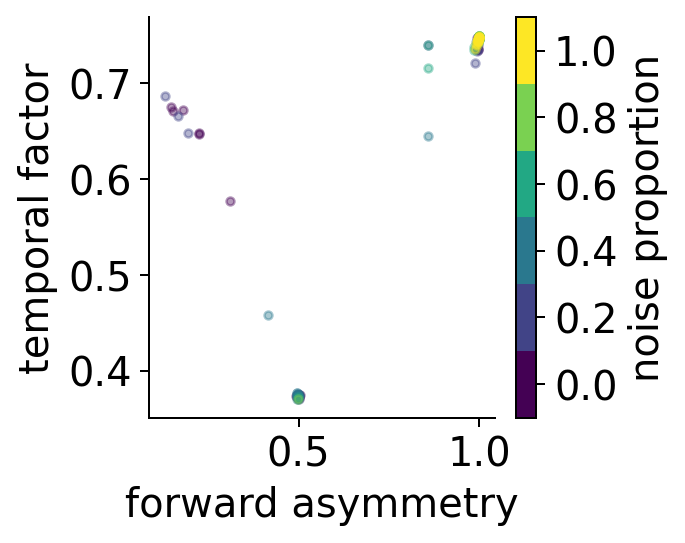

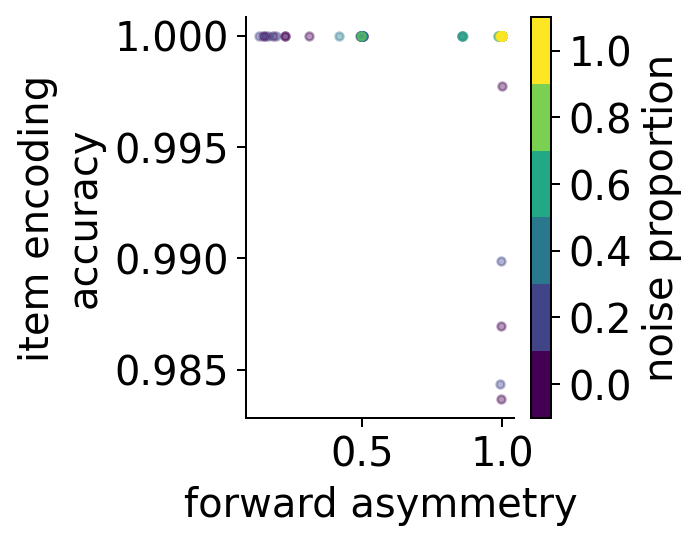

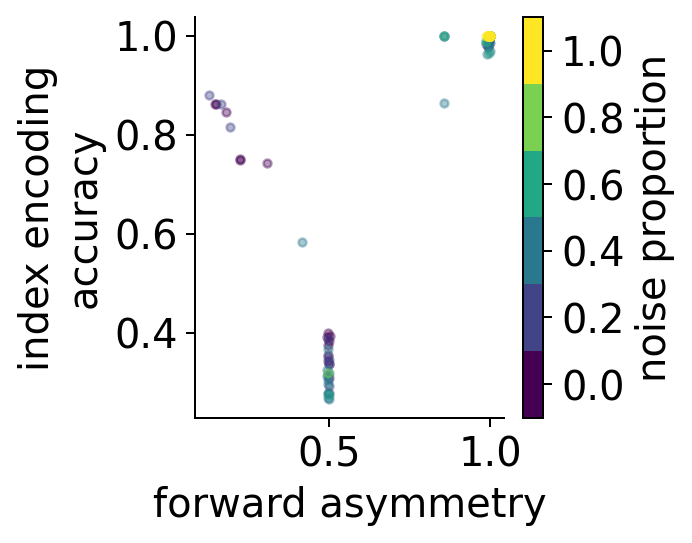

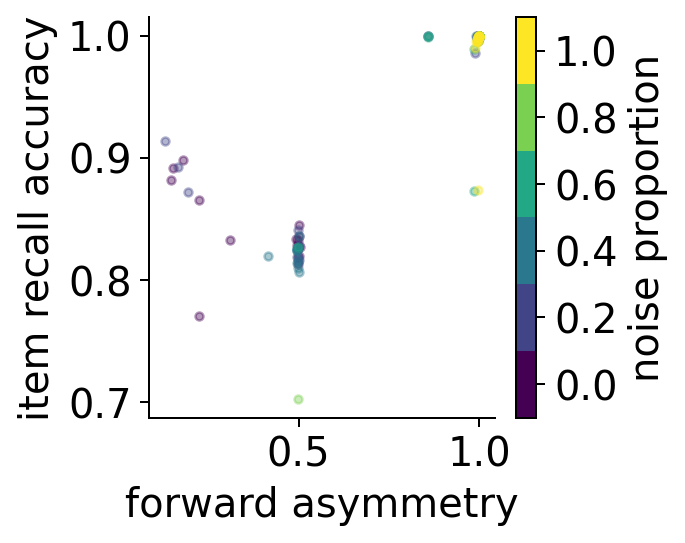

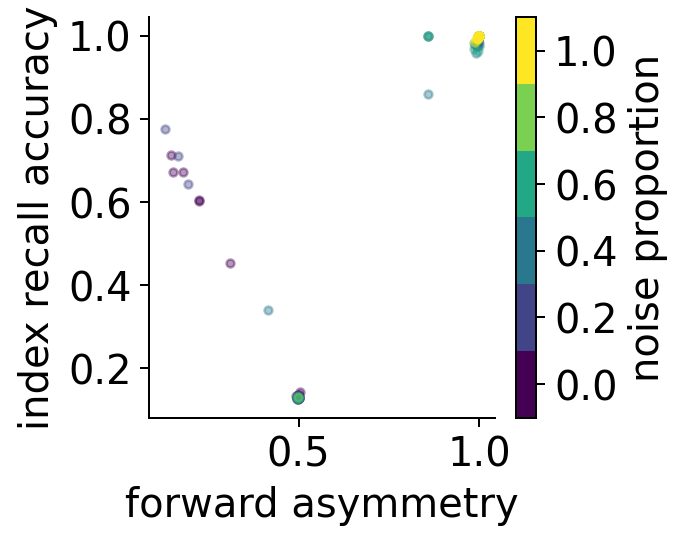

In [23]:
# print(forward_asymmetry.shape, temporal_factor.shape, accuracy.shape, noises.shape)
plot_groups(forward_asymmetry, temporal_factor, "forward asymmetry", "temporal factor")
plot_groups(forward_asymmetry, item_enc_acc, "forward asymmetry", "item encoding\naccuracy")
plot_groups(forward_asymmetry, index_enc_acc, "forward asymmetry", "index encoding\naccuracy")
plot_groups(forward_asymmetry, item_rec_acc, "forward asymmetry", "item recall accuracy")
plot_groups(forward_asymmetry, index_rec_acc, "forward asymmetry", "index recall accuracy")
